In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -u "/content/drive/MyDrive/Hist/C4_withoutPhotometric.zip" -d "/content"

print('\n\nUnZip DONE!')

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

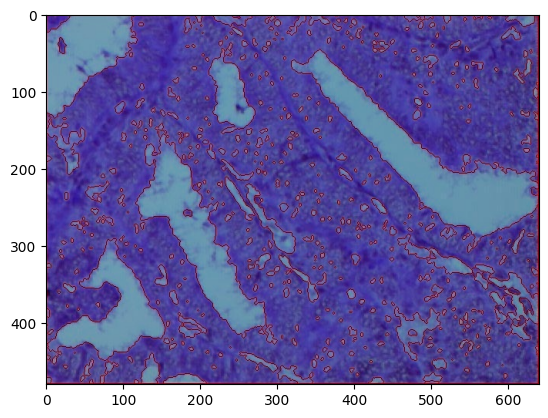

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/content/train"

CATEGORIES = ["EA", "EH", "EP", "NE"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

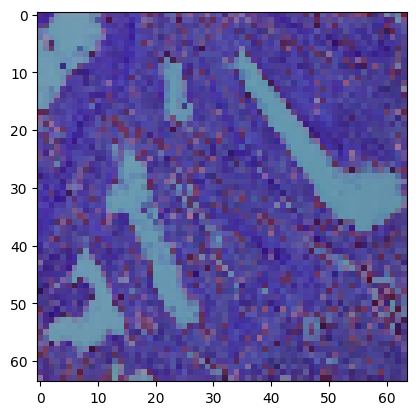

In [5]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [6]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

100%|██████████| 9180/9180 [00:48<00:00, 188.14it/s]


In [7]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X) / 255
X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [8]:
num_classes = 4
input_shape = (64, 64, 3)

(x_train, x_test, y_train, y_test) = train_test_split(X, y,
    test_size=0.2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (18360, 64, 64, 3) - y_train shape: (18360,)
x_test shape: (4590, 64, 64, 3) - y_test shape: (4590,)


In [9]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.1
image_size = 128  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 128 X 128 = 16384
Patch size: 8 X 8 = 64 
Patches per image: 256
Elements per patch (3 channels): 192


In [10]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)

    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply global max pooling to generate a [batch_size, embedding_dim] representation tensor.
    #representation = layers.GlobalMaxPooling1D()(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    #representation = layers.AveragePooling1D()(x)

    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

Removing Ealry Stopping

In [11]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
         optimizer=optimizer,
         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
         metrics=[
             keras.metrics.SparseCategoricalAccuracy(name="acc"),
             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
         ],
     )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

gMLP model

ELU

In [14]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                layers.ELU(alpha=1.0),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will have th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [15]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
gmlp_classifier.summary()
history = run_experiment(gmlp_classifier)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 128, 128, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patches (Patches)                    │ (None, 256, 192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256, 256)            │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 256, 256)            │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,107,211 (4.22 MB)

 Trainable params: 1,107,204 (4.22 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - acc: 0.3612 - loss: 1.7146 - top5-acc: 1.0000 - val_acc: 0.4047 - val_loss: 1.3192 - val_top5-acc: 1.0000 - learning_rate: 0.0030
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - acc: 0.4085 - loss: 1.2873 - top5-acc: 1.0000 - val_acc: 0.4139 - val_loss: 1.2871 - val_top5-acc: 1.0000 - learning_rate: 0.0030
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - acc: 0.4311 - loss: 1.2491 - top5-acc: 1.0000 - val_acc: 0.4134 - val_loss: 1.3108 - val_top5-acc: 1.0000 - learning_rate: 0.0030
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - acc: 0.4438 - loss: 1.2263 - top5-acc: 1.0000 - val_acc: 0.4662 - val_loss: 1.1767 - val_top5-acc: 1.0000 - learning_rate: 0.0030
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - acc: 0.4704 - loss: 1.1757 - top5-acc: 1.0000 - val_acc: 0.5185 - val_loss: 1.1064 - val_top5-acc: 1.0000 - learning_rate: 0.0030
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - ac

In [16]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

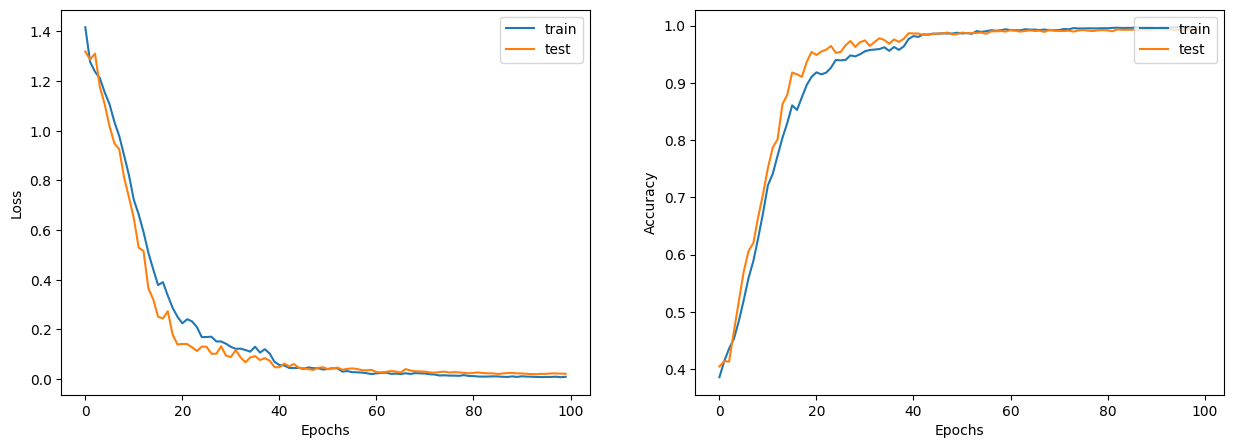

In [17]:
display_learning_curves(history)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


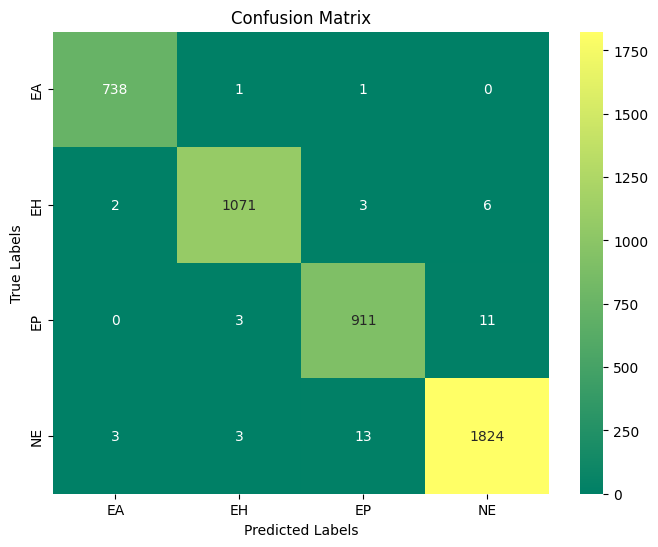

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = gmlp_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="summer",
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
y_pred = gmlp_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Compute accuracy
accuracy = np.trace(confusion_mtx) / np.sum(confusion_mtx)
print("Accuracy:", accuracy)

# Compute precision, recall, and F1-score for each class
class_report = classification_report(y_test, y_pred_classes, target_names=CATEGORIES)
print(class_report)


144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Accuracy: 0.9899782135076253
              precision    recall  f1-score   support

          EA       0.99      1.00      1.00       740
          EH       0.99      0.99      0.99      1082
          EP       0.98      0.98      0.98       925
          NE       0.99      0.99      0.99      1843

    accuracy                           0.99      4590
   macro avg       0.99      0.99      0.99      4590
weighted avg       0.99      0.99      0.99      4590



144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


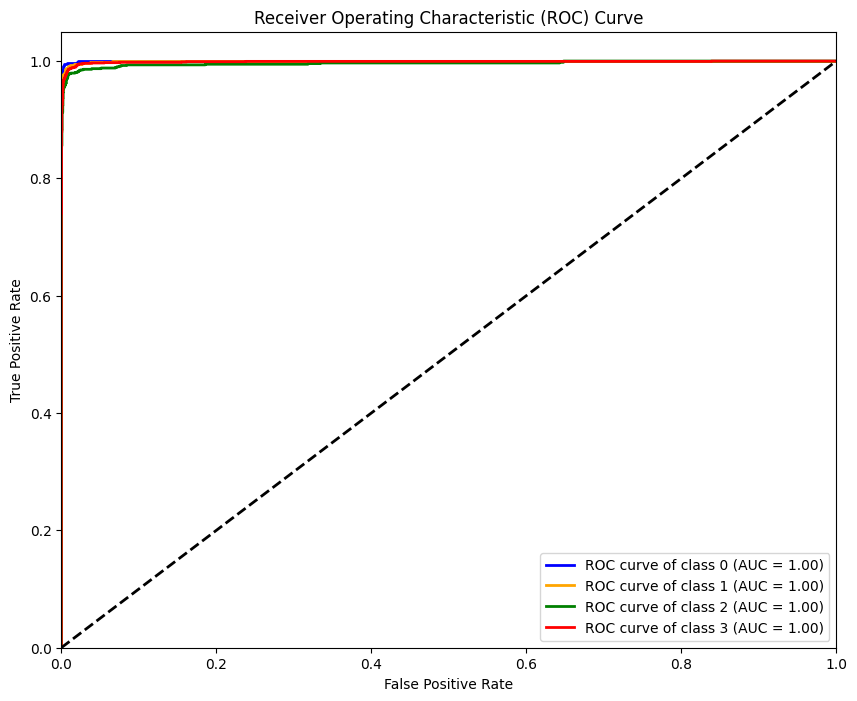

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoded format
y_test_one_hot = label_binarize(y_test, classes=np.arange(num_classes))

# Predict probabilities for the test set
y_pred_prob = gmlp_classifier.predict(x_test)

# Compute the false positive rate (FPR), true positive rate (TPR), and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


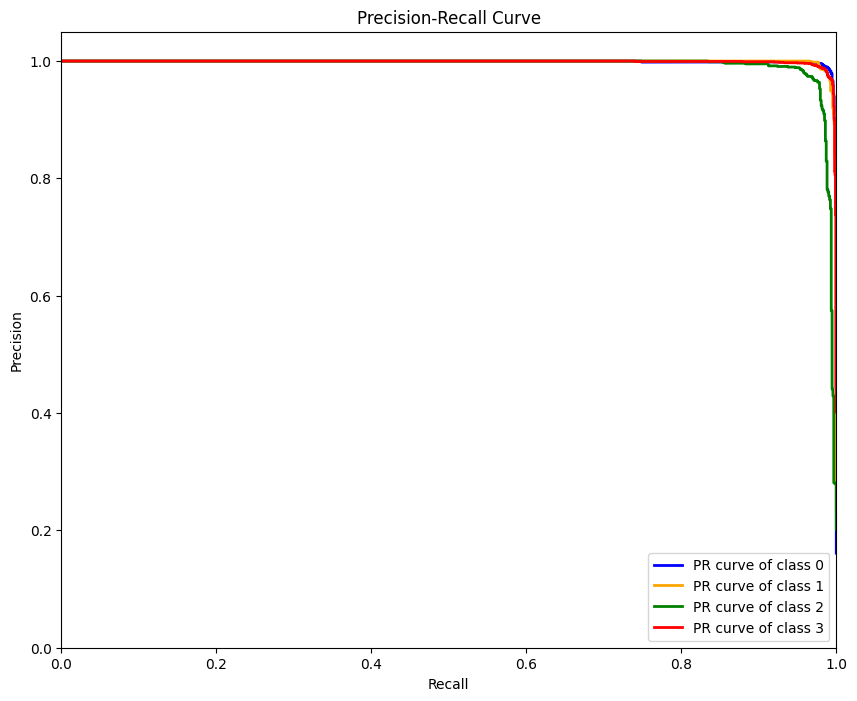

In [22]:
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, and thresholds
precision = {}
recall = {}
thresholds = {}

for i in range(num_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_one_hot[:, i], y_pred_prob[:, i])

# Plot the Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red']
for i in range(num_classes):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2,
             label='PR curve of class {0}'.format(i))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


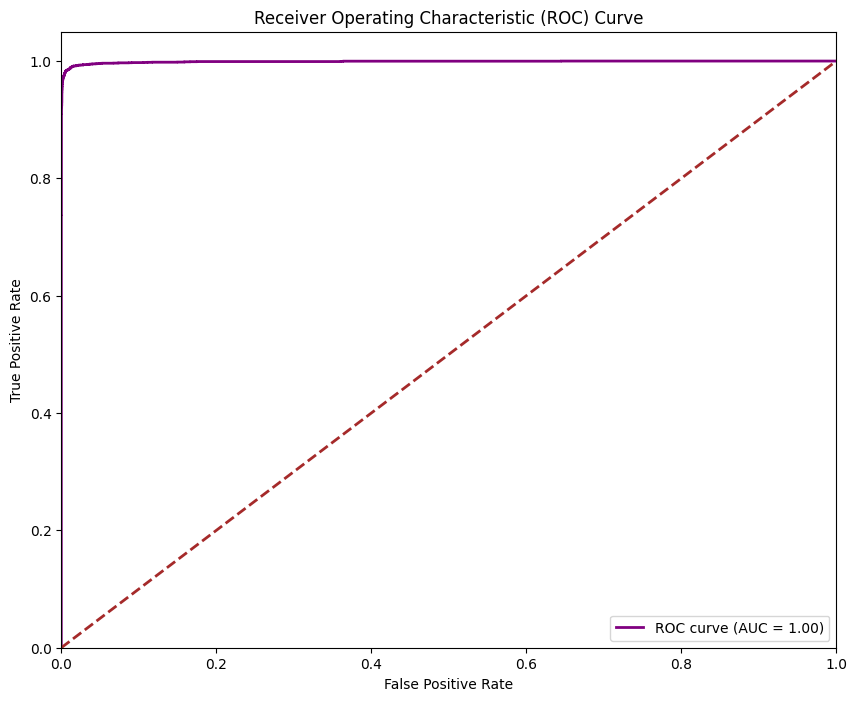

In [23]:
from sklearn.metrics import roc_curve, auc

# Convert labels to one-hot encoded format
y_test_one_hot = label_binarize(y_test, classes=np.arange(num_classes))

# Predict probabilities for the test set
y_pred_prob = gmlp_classifier.predict(x_test)

# Compute the false positive rate (FPR), true positive rate (TPR), and AUC using "micro" averaging
fpr_micro, tpr_micro, _ = roc_curve(y_test_one_hot.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curve for the model
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, color='purple', lw=2, label='ROC curve (AUC = {0:.2f})'.format(roc_auc_micro))
plt.plot([0, 1], [0, 1], color='brown', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

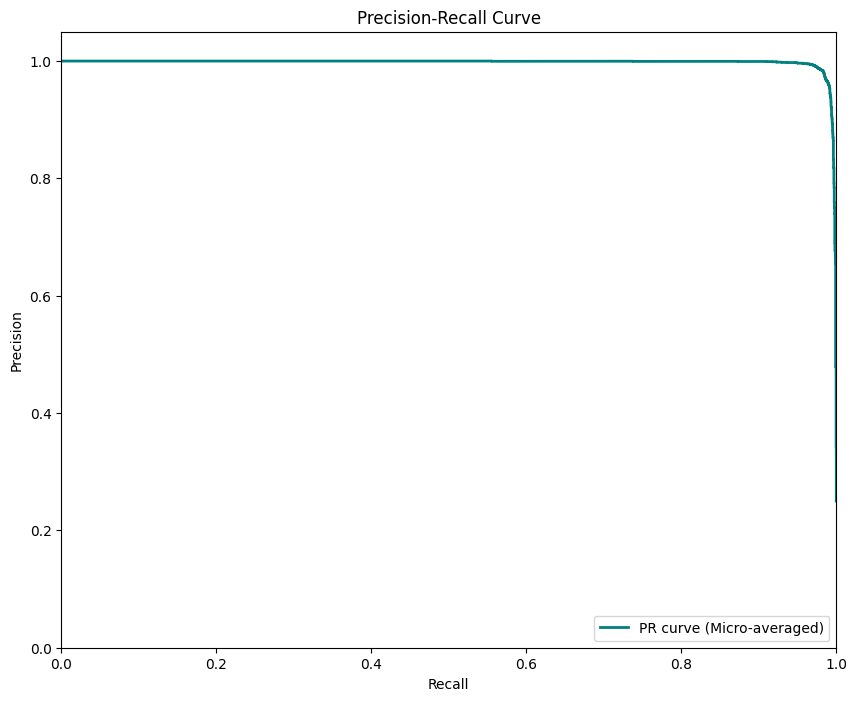

In [29]:
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, and thresholds using "micro" averaging
precision_micro, recall_micro, thresholds_micro = precision_recall_curve(y_test_one_hot.ravel(), y_pred_prob.ravel())

# Plot the Precision-Recall curve for the model
plt.figure(figsize=(10, 8))
plt.plot(recall_micro, precision_micro, color='teal', lw=2, label='PR curve (Micro-averaged)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()